![image.png](plots/portada_boosting.png)

# Introducción
___

¡Bienvenidos a la sesión de introducción a los métodos de boosting! Esta sesión es continuación de la sesión de bagging anterior.

Como bibliografía adicional para estas sesiones recomiendo:
* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). Capítulo 7
* [The Elements of statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf). Capítulos 9 y 10.

Un boosted ensemble es un conjunto de modelos entrenados de manera secuencial en el que cada modelo se centra en reducir los errores del modelo anterior. Hay dos estrategias básicas de ensembles basados en esta idea:

* AdaBoost
* Gradient Boost

Veremos las diferencias entre ambas en esta libreta. Para resolver estas prácticas necesitaremos los paquetes de Python de `numpy`, `pandas`, `matplotlib` y `sklearn`, empecemos cargando estos paquetes:

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(5) # Los resultados del notebook serán los mismos en cada ejecución

import os
num_cores = os.cpu_count()

Además utilizaremos la función `plot_decision_boundary` para representar las fronteras de decisión de los algoritmos en aquellos conjuntos de datos que tengan dos dimensiones.

In [2]:
def plot_decision_boundary(clf, axes, alpha=0.3):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=alpha)

# AdaBoost
___

La idea detrás del AdaBoost (diminutivo de Adaptive Boosting) consiste en construir modelos de manera secuencial, ajustando cada modelo para que se centre en las observaciones mal clasificadas por los modelos anteriores. Esto se consigue utilizando una serie de pesos, que se actualizan en cada iteración. Entrenemos un modelo AdaBoost en el conjunto de datos `moons`. Para ello importamos la función `AdaBoostClassifier`.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

Xm, ym = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(Xm, ym, random_state=42)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=50,
    random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [5]:
prediction = ada_clf.predict(X_test)

print(f'Tasa de aciertos: {accuracy_score(y_test, prediction)}')

Tasa de aciertos: 0.904


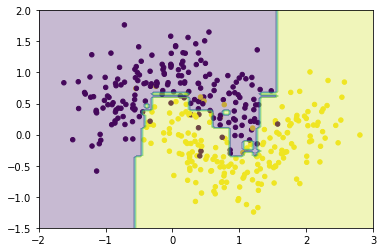

In [6]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20)
plot_decision_boundary(ada_clf, axes=[-2, 3, -1.5, 2])

### <font color='D12828'> Ejercicio: </font>
* Divide el conjunto de datos `BostonHousing` en una parte de train y una de test
* Entrena un ensemble de regresión usando las funciones `DecisionTreeRegressor` y `AdaBoostRegression` usando `n_estimators=20`
* Obtén el error cuadrático medio de la parte de test

In [7]:
from sklearn.datasets import load_boston

boston = load_boston()
x_boston = boston.data
y_boston = boston.target

In [8]:
# Ejercicio

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X_boston_train, X_boston_test, y_boston_train, y_boston_test = train_test_split(x_boston, y_boston, train_size = 0.7, random_state=5)

In [9]:
# Ejercicio 

ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(),
    n_estimators=20)

ada_reg.fit(X_boston_train, y_boston_train)

predicciones = ada_reg.predict(X_boston_test)

mse = mean_squared_error(y_boston_test, predicciones)

print(f'MSE: {mse}')

MSE: 9.403749999999999


Podemos ver que estamos especificando el tipo de modelo base que queremos utilizar en el algoritmo. En este caso usamos `DecisionTreeRegressor`. Igual que sucedía con las técnicas de Bagging, el algoritmo AdaBoost permite usar otros estimadores que no sean árboles, pero ofrece los mejores resultados usando árboles. Además, los árboles nos dan una ventaja adicional, y es que permiten (igual que sucede con los Random Forest) calcular la importancia relativa de las variables en función de cuales son las variables que proporcionan los menores errores de predicción. Para visualizar esto, solo necesitamos acceder a `ada_reg.feature_importance_`:

<BarContainer object of 13 artists>

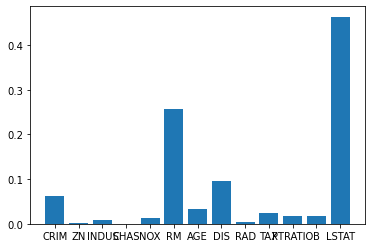

In [10]:
plt.bar(boston.feature_names, ada_reg.feature_importances_)

## Optimización de los parámetros
En estos modelos hay varios parámetros a tener en cuenta:
* Todos los parámetros de los árboles (`max_depth`, `min_samples_leaf` etc). Puedes ver una lista completa [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Dado que AdaBoost es susceptible al overfitting, lo habitual es usar árboles poco complejos.
* `n_estimators`: Número de árbolesa a entrenar. En general, aumentar el número de árboles mejora el resultado, pero llega un punto en el que añadir árboles puede no aportar ninguna mejoría o incluso empeorar resultados por overfitting.
* `learning_rate`: El efecto que el modelo anterior tiene en los pesos del siguiente modelo. Valores muy pequeños ralentizan el aprendizaje, valores muy grandes empeoran las predicciones. Un valor habitual es `learning_rate=0.5`

## `n_estimators`

Una gráfica muy habitual cuando se trabaja con ensembles de árboles es la de representar los errores de predicción frente al número de árboles utilizados en el modelo. Veamos un ejemplo con el conjunto de BostonHousing, para lo que utilizaremos la función `cross_val_score`

In [11]:
from sklearn.model_selection import cross_val_score

n_estimators = np.arange(1, 152, 10)
mse = []

for n_tree in n_estimators:
    ada_reg = AdaBoostRegressor(
        DecisionTreeRegressor(),
        n_estimators=n_tree)
    
    mse_tmp = -1 * np.mean(cross_val_score(ada_reg, X_boston_train, y_boston_train, cv=3, scoring='neg_mean_squared_error', n_jobs=num_cores-1))
    mse.append(mse_tmp)

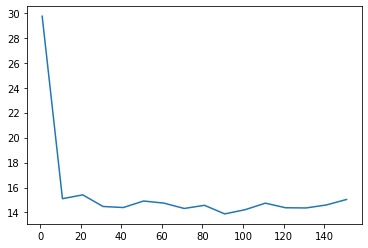

In [12]:
plt.plot(n_estimators, mse)

Podemos ver que a partir 20 arboles, el error se mantiene estable por lo que añadir más árboles al modelo no mejora las predicciones.

### <font color='D12828'> Ejercicio: </font>
Vamos a generar un conjunto de datos para un problema de clasificación. En este conjunto de datos:
1. Construye un arbol de clasificación con la función `DecisionTreeClassifier`. Busca los valores óptimos de los hiperparámetros utilizando las funciones `GridSearchCV` o `RandomizedSearchCV` y calcula la tasa de aciertos en la parte de test.

2. Utilizando un `AdaBoostClassifier`, obtén una gráfica de la tasa de aciertos frente al número de árboles usados. Utiliza árboles tipo stump (se llaman stump a los árboles que tienen profundidad 1).

In [13]:
size = 5000
Xc = np.random.normal(size=(size, 10))

yc = np.zeros(size, dtype='int')

for i in range(size):
    if np.sum(Xc[i,:]**2) > 9.34:
        yc[i] = 1

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, train_size = 2000, random_state=42)

print(f'Dimensiones de X: {Xc.shape}')
print(f'Dimensiones de y: {yc.shape}')

Dimensiones de X: (5000, 10)
Dimensiones de y: (5000,)


In [14]:
# Ejercicio

from sklearn.model_selection import GridSearchCV

clf_tree = DecisionTreeClassifier()
param_grid = [{'max_depth': np.arange(1, 200, 10)}]

grid_search = GridSearchCV(clf_tree, param_grid, cv=5, n_jobs = num_cores-1)

grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_

final_model

DecisionTreeClassifier(max_depth=101)

In [15]:
prediction = final_model.predict(X_test)
accuracy_score(y_test, prediction)

0.7363333333333333

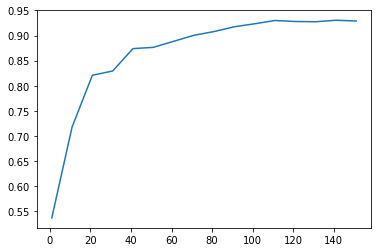

In [16]:
# Ejercicio

acc = []

for n_tree in n_estimators:
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=n_tree)
    acc_tmp = np.mean(cross_val_score(ada_clf, X_train, y_train, cv=5, scoring="accuracy", n_jobs=num_cores-1))
    acc.append(acc_tmp)
    
plt.plot(n_estimators, acc)

Como vemos, con el mejor árbol posible (que tiene una gran complejidad) conseguimos una tasa de acierto de en torno a 0.7. Sin embargo, con un modelo de AdaBoost podemos llegar hasta un 95% de aciertos usando 100 árboles muy sencillos (de profundidad 1) y por tanto muy rápidos de entrenar. Veamos ahora el efecto que tiene la complejidad de los árboles en la calidad de las predicciones:

## `max_depth`

### <font color='D12828'> Ejercicio: </font>
* Obtén la gráfica del número de árboles frente a la tasa de aciertos, pero construye árboles con una profundidad de 50

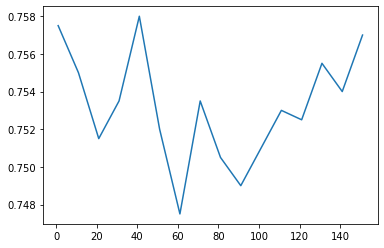

In [17]:
# Ejercicio

acc = []

for n_tree in n_estimators:
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=50),
        n_estimators=n_tree)
    acc_tmp = np.mean(cross_val_score(ada_clf, X_train, y_train, cv=5, scoring="accuracy", n_jobs=num_cores-1))
    acc.append(acc_tmp)
    
plt.plot(n_estimators, acc)

Al aumentar la profundidad de los árboles, construimos un modelo más complejo que da lugar a un gran overfitting. Por esto, conseguimos una tasa de acierto peor que con un modelo más sencillo como el de los stumps. 


### `learning_rate`
Por último, veamos el efecto del `learning_rate`. Recordemos que en AdaBoost, el modelo final se calcula como una media ponderada de todos los modelos. Cada modelo tiene un peso en función de sus errores de predicción. Cuantos menos errores, mayor es el peso del modelo:

$$\alpha_{m}=\eta\log \left(\left(1-\operatorname{err}_{m}\right) / \operatorname{err}_{m}\right)$$

En esta fórmula, $\eta$ es el `learning_rate`. Además, este peso también afecta a la actualización de los demás pesos de las observaciones:

$$w_{i} \leftarrow w_{i} \cdot \exp \left[\alpha_{m} \cdot I\left(y_{i} \neq G_{m}\left(x_{i}\right)\right)\right], i=1,2, \ldots, N$$

### <font color='D12828'> Ejercicio: </font>
* Construye un `AdaBoostClassifier` que utilice 100 árboles de tipo stump. Establece un learning rate de 0.2 y calcula la tasa de aciertos
* Repite el modelo pero utiliza un learning rate de 2.


In [18]:
# Ejercicio

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.2)
ada_clf.fit(X_train, y_train)

prediction = ada_clf.predict(X_test)

accuracy_score(y_test, prediction)

0.8593333333333333

In [19]:
# Ejercicio

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=2)
ada_clf.fit(X_train, y_train)

prediction = ada_clf.predict(X_test)

accuracy_score(y_test, prediction)

0.475

Poner valores pequeños del learning rate puede ralentizar mientras que valores muy grandes pueden afectar a la calidad de las predicciones del algoritmo. Lo habitual es utilizar valores relativamente pequeños (en torno a 0.5). Veamos cómo afecta el learning rate en modelos de tipo SVM.

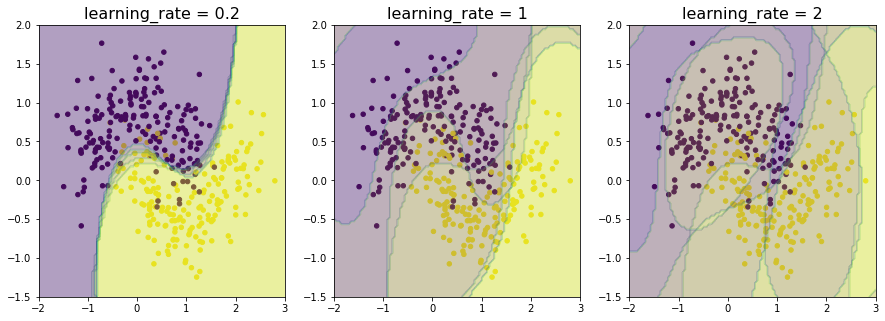

In [20]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(Xm, ym, random_state=42)

n_obs = X_train.shape[0]
plt.figure(figsize=(15, 5))

learning_rate = [0.2, 1, 2]

for idx, lr in enumerate(learning_rate):
    plt.subplot(1, 3, idx+1)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20)
    
    sample_weights = np.ones(n_obs) / n_obs                                  # Pesos iniciales
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * n_obs)  # Se entrena el modelo
        y_pred = svm_clf.predict(X_train)                                    # Se obtienen predicciones

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()   # 2.2
        alpha = lr * np.log((1 - r) / r)                                     # 2.3
        sample_weights[y_pred != y_train] *= np.exp(alpha)                   # 2.4
        sample_weights /= sample_weights.sum()                               # Normalizacion

        plot_decision_boundary(svm_clf, axes=[-2, 3, -1.5, 2], alpha=0.1)
        plt.title(f'learning_rate = {lr}', fontsize=16)
        

# Gradient Boosting
___

Los métodos basados en Gradient boosting se centran en el uso del algoritmo de optimización de __gradient descent__ para construir un modelo secuencial en el que en cada iteración, el modelo se construye mejorando las predicciones de los residuos del modelo anterior.

Veamos un ejemplo con un conjunto de datos de regresión sencillo:

In [21]:
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [22]:
# Visualizar predicciones

def plot_predictions(regressors, X, y, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(np.min(X), np.max(X), 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.scatter(X[:, 0], y, c='blue', s=10, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)

Entrenamos al primer modelo

In [23]:
# Modelo 1

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Text(0.5, 1.0, 'Ensemble predictions')

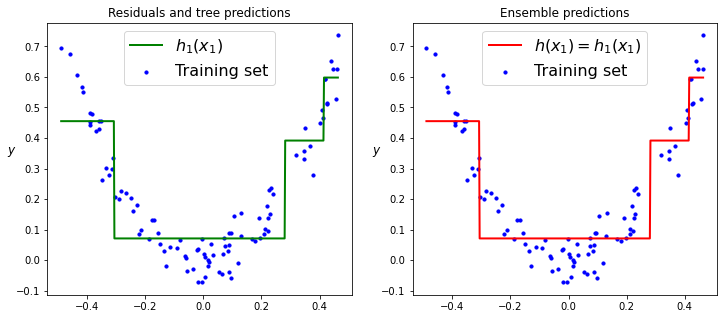

In [24]:
plt.figure(figsize=(12, 5))

# Residuos
plt.subplot(1,2,1)
plot_predictions([tree_reg1], X, y, label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=12, rotation=0)
plt.title("Residuals and tree predictions", fontsize=12)

# Datos
plt.subplot(1,2,2)
plot_predictions([tree_reg1], X, y, label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=12, rotation=0)
plt.title("Ensemble predictions", fontsize=12)

Entrenamos al segundo modelo en los residuos del primer modelo

In [25]:
# Modelo 2

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Text(0.5, 1.0, 'Ensemble predictions')

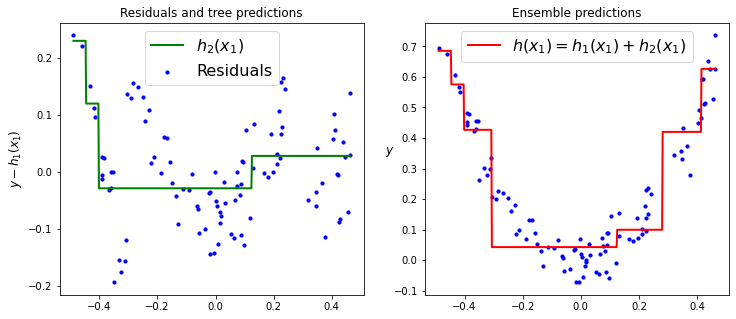

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plot_predictions([tree_reg2], X, y2, label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=12)
plt.title("Residuals and tree predictions", fontsize=12)

plt.subplot(1,2,2)
plot_predictions([tree_reg1, tree_reg2], X, y, label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=12, rotation=0)
plt.title("Ensemble predictions", fontsize=12)

Entrenamos al tercer modelo en los residuos del segundo modelo. El modelo final será la suma de los tres modelos.

In [27]:
# Modelo 3

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Text(0.5, 1.0, 'Ensemble predictions')

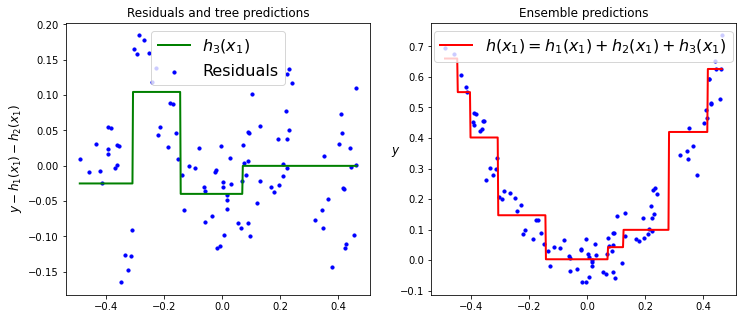

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plot_predictions([tree_reg3], X, y3, label="$h_3(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=12)
plt.title("Residuals and tree predictions", fontsize=12)

plt.subplot(1,2,2)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.ylabel("$y$", fontsize=12, rotation=0)
plt.title("Ensemble predictions", fontsize=12)

Obtenemos el mismo resultado si utilizamos la implementación de sklearn `GradientBoostingRegressor`:

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

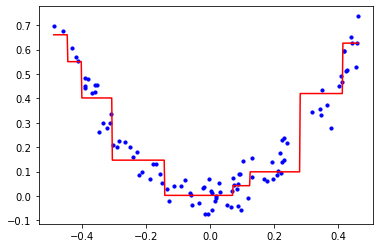

In [30]:
x1 = np.linspace(np.min(X), np.max(X), 500).reshape((-1, 1))
y_pred = gbrt.predict(x1)

plt.scatter(X[:, 0], y, c='blue', s=10)
plt.plot(x1, y_pred, 'r-')

### <font color='D12828'> Ejercicio: </font>

* Utiliza el conjunto de datos de clasificación visto antes `Xc`, `yc` para entrenar un modelo `GradientBoostingClassifier`


In [31]:
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, train_size = 2000, random_state=42)

In [32]:
# Ejercicio

from sklearn.ensemble import GradientBoostingClassifier

gbct = GradientBoostingClassifier(max_depth=1, n_estimators=150)

gbct.fit(X_train, y_train)
p = gbct.predict(X_test)

accuracy_score(y_test, p)

0.8476666666666667

## Funciones de pérdida

Como decíamos, la ventaja de los modelos basados en Gradient Boosting es que están formulados como un problema de optimización con una función de pérdida. Habitualmente en problemas de regresión esa función de pérdida se toma como los mínimos cuadrados (least squares, o ls por sus siglas):
* $L(y, F(x)) = \sum_i(y_i-F(x))^2$ 

Pero es posible sustituir esta función por otras alternativas. En concreto, sklearn implementa también la función de pérdida del Least Absolute Deviation (lad)
* $L(y, F(x)) = \sum_i\vert y_i-F(x)\vert$ 

Esta función proporciona una una estimación de la mediana de la variable respuesta, que es mucho más robusta frente a la presencia de outliers. Esto hace a los gradient boostings construidos en base al least absolute error modelos mucho más robustos.

### <font color='D12828'> Ejercicio: </font>

* En el conjunto de datos de Boston Housing, entrena un modelo Gradient Boosting usando la función de pérdida del Least Absolute Deviation. Para ello incluye el parámetro `loss='lad'`

In [33]:
# Ejercicio

from sklearn.metrics import mean_absolute_error

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=25, loss='lad', random_state=42)
gbrt.fit(X_boston_train, y_boston_train)

p = gbrt.predict(X_boston_test)
mean_absolute_error(y_boston_test, p)

3.1944063878728444

## `learning_rate`

El algoritmo de Gradient Boosting también incluye un parámetro de learning rate, que escala la contribución de cada modelo. 

$$
F_{m}(x)=F_{m-1}(x)+\eta \cdot h_{m}(x)
$$
Si establecemos un valor pequeño del learning rate, ralentizamos el aprendizaje (serán necesarios más árboles), pero el resultado final proporcionará normalemente mejores predicciones. Un valor habitual para este parámetro es 0.1.

### <font color='D12828'> Ejercicio: </font>
* Entrena un Gradient Boosting classifier en el conjunto de datos `Xc` `yc` utilizando 600 árboles y un learning rate de 0.1. Obtén la tasa de correctamente clasificados del modelo.
* Entrena otro Gradient Boosting classifier en el conjunto de datos `Xc` `yc` utilizando 100 árboles y un learning rate de 1. Obtén la tasa de correctamente clasificados del modelo.
* Entrena un último Gradient Boosting classifier en el conjunto de datos `Xc` `yc` utilizando 25 árboles y un learning rate de 2. Obtén la tasa de correctamente clasificados del modelo.

In [34]:
# Ejercicio

gbct = GradientBoostingClassifier(max_depth=1, n_estimators=600, learning_rate=0.1)

gbct.fit(X_train, y_train)
p = gbct.predict(X_test)

accuracy_score(y_test, p)

0.9033333333333333

In [35]:
# Ejercicio

gbct = GradientBoostingClassifier(max_depth=1, n_estimators=100, learning_rate=1)

gbct.fit(X_train, y_train)
p = gbct.predict(X_test)

accuracy_score(y_test, p)

0.917

In [36]:
# Ejercicio

gbct = GradientBoostingClassifier(max_depth=1, n_estimators=25, learning_rate=2)

gbct.fit(X_train, y_train)
p = gbct.predict(X_test)

accuracy_score(y_test, p)

0.6053333333333333

Como podemos ver, existe un trade-off entre `n_estimators` y `learning_rate`. Cuanto más pequeño es el learning rate, mayor es el número de estimadores necesarios para conseguir una tasa de aciertos similar. Sin embargo, si el learning_rate es muy elevado el modelo no generalizará bien y las predicciones empeorarán incluso aunque usemos pocos árboles

## subsample

Los modelos GradientBoosting también incluyen un hiperparámetro llamado `subsample`, que especifica el procentaje de observaciones del conjunto de datos que serán utilizadas para entrenar cada árbol. Por ejemplo, si especificamos `subsample=0.25` usaremos un 25\% de los datos tomados al azar para entrenar cada modelo. Por defecto este parámetro toma el valor 1 (usamos todo el conjunto de datos) pero puede ser interesante tenerlo presente. Su uso ayuda a reducir el overfitting, pero aumenta el sesgo del modelo. Un beneficio añadido es que los modelos se entrenan mucho más rápido. Este método es lo que se conoce como __Stochastic Gradient Boosting.__


In [37]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=25, random_state=42, subsample=0.5)
gbrt.fit(X_boston_train, y_boston_train)

p = gbrt.predict(X_boston_test)
mean_squared_error(y_boston_test, p)

13.999275155699934

In [38]:
import time

start_time = time.time()
gbct = GradientBoostingClassifier(max_depth=2, n_estimators=800, random_state=42, subsample=0.25)
gbct.fit(X_train, y_train)
p = gbct.predict(X_test)
acc = accuracy_score(y_test, p)
end_time = time.time()
print(f'Tiempo de ejecución con subsample=0.25: {np.round(end_time-start_time, 3)} segundos')
print(f'Tasa de aciertos: {acc}')

Tiempo de ejecución con subsample=0.25: 0.972 segundos
Tasa de aciertos: 0.941


In [39]:
start_time = time.time()
gbct = GradientBoostingClassifier(max_depth=2, n_estimators=800, random_state=42)
gbct.fit(X_train, y_train)
p = gbct.predict(X_test)
acc = accuracy_score(y_test, p)
end_time = time.time()
print(f'Tiempo de ejecución con subsample=1: {np.round(end_time-start_time, 3)} segundos')
print(f'Tasa de aciertos: {acc}')

Tiempo de ejecución con subsample=1: 2.457 segundos
Tasa de aciertos: 0.922


# XGBOOST
___

XGBoost es la versión vitaminada de Gradient Boosting. Incluye muchas mejoras a nivel computacional y de mejora de predicción, entre las que destacan:
* Ejecución en paralelo
* Poda de los árboles
* Gestión de datos ausentes
* Regularización para controlar el overfitting

Para utilizar los modelos de XGBoost, es necesario instalar previamente este paquete usando el comando `pip install xgboost` en el terminal de anaconda. Veamos un ejemplo con el conjunto de datos de boston.

In [40]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_boston_train, y_boston_train)

y_pred = xgb_reg.predict(X_boston_test)

mean_squared_error(y_boston_test, y_pred)

11.966377893868534

## Optimización de hiperparámetros

Los modelos tipo XGBoost tienen una gran cantidad de parámetros destinados en gran medida a controlar el riesgo de overfitting. Utilizar alternativas como GridSearch enseguida resulta computacionalmente irrealizable. En estos casos una de las mejores opciones es utilizar `RandomizedSearchCV`

In [41]:
from sklearn.model_selection import RandomizedSearchCV

xgb_reg = xgboost.XGBRegressor()

params = [{'eta':[0.05, 0.1, 0.2, 0.3], 'max_depth':[2, 4, 6, 8], 'subsample': [0.4, 0.6, 0.8, 1]}]

rv_search = RandomizedSearchCV(xgb_reg, params, cv=5, n_iter=20)
rv_search.fit(X_boston_train, y_boston_train)

final_model = rv_search.best_estimator_
print(f'Parámetros optimos: {rv_search.best_params_}')

Parámetros optimos: {'subsample': 1, 'max_depth': 8, 'eta': 0.2}


In [42]:
y_pred = final_model.predict(X_boston_test)
mean_squared_error(y_boston_test, y_pred)

10.796653603169208

Al igual que en los modelos anteriores, los XGBoost también ofrecen información sobre la importancia de las variables:

<BarContainer object of 13 artists>

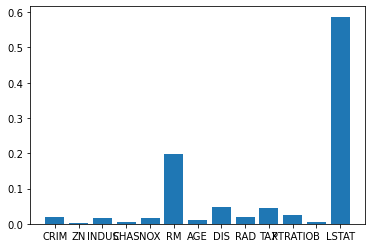

In [43]:
plt.bar(boston.feature_names, final_model.feature_importances_)

### <font color='D12828'> Ejercicio: </font>
* Utilizando el conjunto de datos de clasificación de cancer de mama `breast_cancer`, construye un modelo xgboost optimizando el learning rate, la profundidad de los árboles y la proporción de observaciones utilizadas en cada árbol.
* Como parámetros adicionales del modelo, establece `use_label_encoder=False`, `eval_metric='error'`
* Evalúa la calidad de tu modelo en una parte de test
* Obtén una gráfica de la importancia de las variables.

In [44]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
X_bc, y_bc = bc.data, bc.target

In [45]:
# Ejercicio

X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(X_bc, y_bc, test_size=0.2, random_state=42, stratify=y_bc)

xgb_clf = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='error')

params = [{'eta':[0.05, 0.1, 0.2, 0.3], 'max_depth':[2, 4, 6, 8], 'subsample': [0.4, 0.6, 0.8, 1]}]

rv_search = RandomizedSearchCV(xgb_clf, params, cv=5, n_iter=20)
rv_search.fit(X_bc_train, y_bc_train)

final_model = rv_search.best_estimator_

y_pred = final_model.predict(X_bc_test)
accuracy_score(y_bc_test, y_pred)

0.9473684210526315

## `early_stopping_rounds`

Una función muy interesante implementada en XGBoost es la de early stopping. Dado que en este ensemble los modelos se construyen de manera secuencial, en lugar de construir tantos modelos como se especifique en el parámetro `n_estimators`, podemos evaluar la capacidad predictiva del modelo en cada iteración. Si durante un número de rondas igual `early_stopping_rounds` la predicción no mejora, el algoritmo dejará de construir y añadir árboles. Esto puede reducir en gran medida la complejidad del ensemble, el riesgo de overfitting y mejorar la capacidad predictiva. Veamos un ejemplo:

In [46]:
xgb_reg = xgboost.XGBRegressor(n_estimators=2000, subsample=0.8, max_depth= 4, eta=0.1)

xgb_reg.fit(X_boston_train, y_boston_train, eval_set=[(X_boston_test, y_boston_test)], early_stopping_rounds=10, verbose=False)

p = xgb_reg.predict(X_boston_test)
mean_squared_error(y_boston_test, p)

7.950430792776171

Esto permite establecer a priori, valores muy elevados de `n_estimators` sabiendo que si la predicción no mejora, la ejecución se detendrá.

### <font color='D12828'> Ejercicio: </font>
* Utiliza early stopping en el conjunto de datos de Breast Cancer. Usa los parámetros óptimos alcanzados con Random search en el ejercicio anterior.


In [47]:
xgb_clf = xgboost.XGBClassifier(n_estimators=2000, subsample=0.4, max_depth= 8, eta=0.1, use_label_encoder=False, eval_metric='error')

xgb_clf.fit(X_bc_train, y_bc_train, eval_set=[(X_bc_test, y_bc_test)], early_stopping_rounds=5)

p = xgb_clf.predict(X_bc_test)
accuracy_score(y_bc_test, p)

[0]	validation_0-error:0.12281
[1]	validation_0-error:0.08772
[2]	validation_0-error:0.07895
[3]	validation_0-error:0.04386
[4]	validation_0-error:0.05263
[5]	validation_0-error:0.04386
[6]	validation_0-error:0.04386
[7]	validation_0-error:0.04386


0.956140350877193

# Fin
___